In [1]:

import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
import sklearn.pipeline
%matplotlib inline


/var/folders/7p/v4s1vzgj3fz1cnk_dqbddljr0000gn/T/ipykernel_62175/1553930727.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Read in the Data 

In [2]:
data = pd.read_csv("breast-cancer.csv")
data = data.drop("id", axis = 1)
data = data.replace({"M","B"},{1,0})
data = data.sample(frac=1)
Y = data["diagnosis"]
X = data.drop("diagnosis",axis = 1)
X.head()




/var/folders/7p/v4s1vzgj3fz1cnk_dqbddljr0000gn/T/ipykernel_62175/2462508884.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({"M","B"},{1,0})


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
97,9.787,19.94,62.11,294.5,0.10240,0.05301,0.006829,0.007937,0.1350,0.06890,...,10.92,26.29,68.81,366.1,0.1316,0.09473,0.02049,0.02381,0.1934,0.08988
440,10.970,17.20,71.73,371.5,0.08915,0.11130,0.094570,0.036130,0.1489,0.06640,...,12.36,26.87,90.14,476.4,0.1391,0.40820,0.47790,0.15550,0.2540,0.09532
460,17.080,27.15,111.20,930.9,0.09898,0.11100,0.100700,0.064310,0.1793,0.06281,...,22.96,34.49,152.10,1648.0,0.1600,0.24440,0.26390,0.15550,0.3010,0.09060
5,12.450,15.70,82.57,477.1,0.12780,0.17000,0.157800,0.080890,0.2087,0.07613,...,15.47,23.75,103.40,741.6,0.1791,0.52490,0.53550,0.17410,0.3985,0.12440
463,11.600,18.36,73.88,412.7,0.08508,0.05855,0.033670,0.017770,0.1516,0.05859,...,12.77,24.02,82.68,495.1,0.1342,0.18080,0.18600,0.08288,0.3210,0.07863


In [3]:
# check for null values 
data.isnull().sum().sum()

0

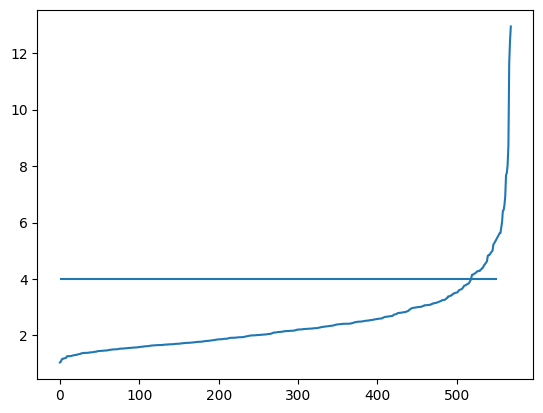

In [4]:
### Add preprocessing here (or inside the pipes)
## looking for outliers wit DBSCAN 
## finding besteps 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
scaler = StandardScaler()
pca = PCA(n_components=0.95, svd_solver="full")
processed_data = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X))) # scales and reduces dimension of data to improve distance based models
nn = NearestNeighbors(n_neighbors=4)
nn.fit(processed_data)
distance_matrix = nn.kneighbors(processed_data)[0]
distances = np.sort(distance_matrix[:,3])
plt.plot(distances)
plt.hlines(y=4, xmin=0, xmax=550)
# best eps around 3.75
plt.show()

Estimated no. of clusters: 2
Estimated no. of noise points: 31


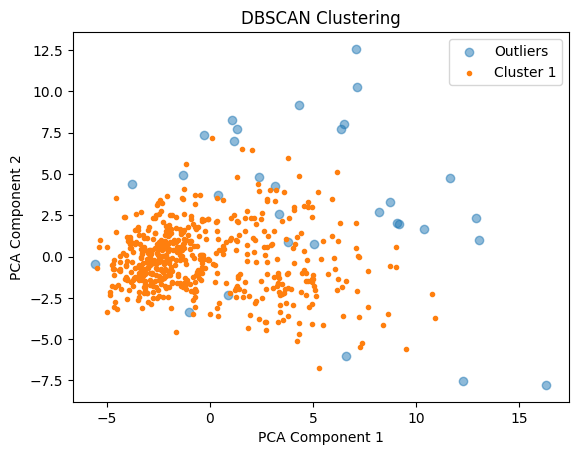

In [5]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=4, min_samples=4).fit(processed_data)
labels = db.labels_
no_clusters = len(np.unique(labels))
no_noise = np.sum(np.array(labels) == -1, axis=0)
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

for label in np.unique(labels):
    if label == -1:
        plt.scatter(processed_data.loc[labels == label, 0], processed_data.loc[labels == label, 1], 
                    marker='o', label='Outliers', alpha=0.5)
    else:
        plt.scatter(processed_data.loc[labels == label, 0], processed_data.loc[labels == label, 1], 
                    marker='.', label=f'Cluster {label + 1}')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()


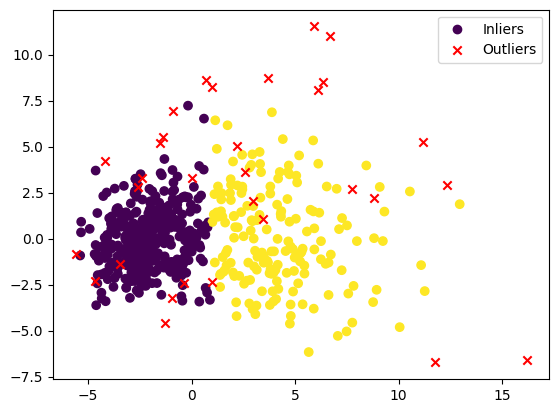

In [15]:
from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
# import matplotlib.pyplot as plt
# import numpy as np

# Detect outliers using Local Outlier Factor
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
outlier_labels = lof.fit_predict(X_scaled)


inliers = X_scaled[outlier_labels == 1]
outliers = X_scaled[outlier_labels == -1]

# Perform KMeans clustering on the original scaled data
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(inliers)
labels = kmeans.labels_

pca = PCA(n_components=2).fit(inliers)
inliers_PCA = pca.transform(inliers)
outliers_PCA = pca.transform(outliers)



plt.scatter(inliers_PCA[:, 0], inliers_PCA[:, 1], c=labels, cmap='viridis', label='Inliers')
plt.scatter(outliers_PCA[:, 0], outliers_PCA[:, 1], c='red', marker='x', label='Outliers')
plt.legend()
plt.show()

In [7]:
# Print metrics
from sklearn import metrics

# Using the code for calculating and printing 
# the confusion matrix from Assignment 3
def get_confusion(test_data, results):
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    for i in range(len(test_data)):
        expected = test_data[i]
        if(expected):
            if (results[i]):
                TP += 1
            else:
                FN += 1
        else:
            if (results[i]): #is neg guessed pos
                FP += 1
            else: 
                TN += 1



    return TN, TP, FN, FP 

def print_confusion_matrix(TP, FN, FP, TN):
    
    table_data = [[TP,FN],[FP,TN]]
    df = pd.DataFrame(table_data, columns =['Predicted 1','Predicted 0'])
    df = df.rename(index={0: 'Actual 1', 1: 'Actual 0'})
    display(df)

# takes in a list of predicted values and test sets for each fold of crossvalidation
def PrintMetrics_list(y_actual, y_pred):
    accuracies = []
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    loops = len(y_pred)
    for i in range(loops):
        accuracies.append(sk.metrics.accuracy_score(y_actual[i],y_pred[i]))
        confusion = get_confusion(list(y_actual[i]),list(y_pred[i]))
        tn += confusion[0]
        tp += confusion[1]
        fn += confusion[2]
        fp += confusion[3]
    accuracy = np.average(accuracies)
    print("Accuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("Precision: ",precision)
    print("Recall:",recall)

def PrintMetrics(y_actual, y_pred):
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    accuracy = sk.metrics.accuracy_score(y_actual,y_pred)
    confusion = get_confusion(y_actual,y_pred)
    tn += confusion[0]
    tp += confusion[1]
    fn += confusion[2]
    fp += confusion[3]
    
    print("Accuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("Precision: ",precision)
    print("Recall:",recall)
    



In [8]:
outputs = []


In [9]:


#Random Forest
from sklearn import model_selection
from sklearn import ensemble
param_grid = { # mess with these
    "max_depth": list(range(30,40)),
    "min_samples_leaf": list(range(1,6,2))
}

inner = sk.model_selection.GridSearchCV(sk.ensemble.RandomForestClassifier(),param_grid)
kf = sk.model_selection.KFold(n_splits=5)
actuals = []
preds = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen max_depth:",inner.best_estimator_.get_params()["max_depth"])
    print("Chosen min_samples_leaf:",inner.best_estimator_.get_params()["min_samples_leaf"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["Random Forest",actuals,preds])




KeyboardInterrupt: 

In [ ]:
#ADA Boosting
param_grid = {
    'n_estimators': list(range(100,150,10)),
}
boost = sk.ensemble.AdaBoostClassifier(algorithm="SAMME")
inner = sk.model_selection.GridSearchCV(boost,param_grid,cv= 5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_estimators:",inner.best_estimator_.get_params()["n_estimators"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["ADA Boosting",actuals,preds])



Chosen n_estimators: 100
Chosen n_estimators: 110
Chosen n_estimators: 130
Chosen n_estimators: 120
Chosen n_estimators: 110


In [ ]:
#SVM
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
svc = sk.svm.SVC()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("svc",svc)])

param_grid = {
    'pca__n_components': list(range(10, 15)),
    'svc__kernel': ["linear","rbf"]
}
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("Chosen kernel:",inner.best_estimator_.get_params()["svc__kernel"])

    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["SVM",actuals,preds])


Chosen n_components: 10
Chosen kernel: rbf
Chosen n_components: 10
Chosen kernel: rbf
Chosen n_components: 10
Chosen kernel: rbf
Chosen n_components: 10
Chosen kernel: linear
Chosen n_components: 11
Chosen kernel: linear


In [ ]:
#Nearest Neighbor
param_grid = { #mess with these
    'pca__n_components': list(range(7,13)),
    'knn__n_neighbors': list(range(3,7))
}
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
knn = sk.neighbors.KNeighborsClassifier()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("knn",knn)])
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv = 5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("Chosen n_neighbors:",inner.best_estimator_.get_params()["knn__n_neighbors"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["K Nearest Neighbor",actuals,preds])



Chosen n_components: 11
Chosen n_neighbors: 3
Chosen n_components: 8
Chosen n_neighbors: 4
Chosen n_components: 11
Chosen n_neighbors: 3
Chosen n_components: 11
Chosen n_neighbors: 3
Chosen n_components: 11
Chosen n_neighbors: 5


In [ ]:
#Simple Neural Net
from sklearn import neural_network
scaler = sk.preprocessing.StandardScaler()
nn = sk.neural_network.MLPClassifier(learning_rate="invscaling",learning_rate_init=0.1)
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("nn",nn)])
param_grid = {
    "nn__hidden_layer_sizes": [(30,),(40,),(50,),(60,),(70,),(80,)],
    "nn__activation": ["logistic","tanh","relu"],
    "nn__max_iter" : [200,250,300,350]
}
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen hidden_layer_sizes:",inner.best_estimator_.get_params()["nn__hidden_layer_sizes"])
    print("Chosen activation:",inner.best_estimator_.get_params()["nn__activation"])
    print("Chosen max_iter:",inner.best_estimator_.get_params()["nn__max_iter"])

    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["Neural Nets",actuals,preds])



Chosen hidden_layer_sizes: (30,)
Chosen activation: relu
Chosen max_iter: 300
Chosen hidden_layer_sizes: (60,)
Chosen activation: tanh
Chosen max_iter: 300
Chosen hidden_layer_sizes: (30,)
Chosen activation: logistic
Chosen max_iter: 250
Chosen hidden_layer_sizes: (60,)
Chosen activation: logistic
Chosen max_iter: 200
Chosen hidden_layer_sizes: (50,)
Chosen activation: logistic
Chosen max_iter: 250


In [ ]:
for output in outputs:
    print("Metrics for",output[0])
    PrintMetrics_list(output[1],output[2])
    print()

Metrics for Random Forest
Accuracy: 0.9648657040832168


,Predicted 1,Predicted 0
Actual 1,200,12
Actual 0,8,349


Precision:  0.9615384615384616
Recall: 0.9433962264150944

Metrics for ADA Boosting
Accuracy: 0.9718987734823784


,Predicted 1,Predicted 0
Actual 1,201,11
Actual 0,5,352


Precision:  0.9757281553398058
Recall: 0.9481132075471698

Metrics for SVM
Accuracy: 0.9736531594472908


,Predicted 1,Predicted 0
Actual 1,203,9
Actual 0,6,351


Precision:  0.9712918660287081
Recall: 0.9575471698113207

Metrics for K Nearest Neighbor
Accuracy: 0.9666356155876417


,Predicted 1,Predicted 0
Actual 1,196,16
Actual 0,3,354


Precision:  0.9849246231155779
Recall: 0.9245283018867925

Metrics for Neural Nets
Accuracy: 0.9718987734823784


,Predicted 1,Predicted 0
Actual 1,204,8
Actual 0,8,349


Precision:  0.9622641509433962
Recall: 0.9622641509433962



In [ ]:
## save model here?